from https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [2]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [13]:
data1 = read_text("C:/WinPython_64bit/notebooks/shopee code league 2020/shopee-product-title-translation-open/dev_tcn.txt")
china = to_lines(data1)
china = array(china)

In [14]:
data2 = read_text("C:/WinPython_64bit/notebooks/shopee code league 2020/shopee-product-title-translation-open/dev_en.txt")
eng = to_lines(data2)
eng = array(eng)

In [6]:
china = china[:500,:]
print(china)

[['OPPO A75 A75s A73 手机壳 软壳 挂绳壳 大眼兔硅胶壳']
 ['SOFT 99 鍍膜車蠟(強力撥水型)']
 ['低糖芒果乾 250g 臻御行']
 ['＊小徑文化＊日本進口ROUND TOP space craft - diamond (SC-MK-010)']
 ['Hello Kitty 凱蒂貓 KITTY 涼鞋 童鞋 白/紅色 小童 no739']
 ['雷鳥 LT-234 日式木紋桌墊 45 x 60 cm / 片']
 ['狂砂小子DVD VOL-08']
 ['ANACOMDA 巨蟒 T1 泰坦系列 120GB SSD固態硬碟']
 ['iFairies 單肩斜背包側背包肩背包【49146】']
 ['大雪山農場 山苦瓜茶20包/盒']
 ['高露潔 雙效潔淨牙刷單支']
 ['Apieu Color Lip Pencil MATT絲緞']
 ['芮菲客米蘭玫瑰金鋼珠筆']
 ['海底總動員2 玻璃磁鐵 多莉款_野獸國']
 ['natural甘草瓜子160g 南瓜子150g Shopping168']
 ['PAPAGO 368miniHD行車記錄器']
 ['ISTA 伊士達 4分濾網頭 2pcs']
 ['DOT聚點 Adidas Essentials Chest Logo 方形 方塊 灰藍 連帽 帽T 男款 B45729']
 ['流蘇立體縫線莫卡辛鞋 藍/黑色【DF337】']
 ['新品時尚可愛寶寶繡花連衣裙 洋裝']
 ['客制化 泡泡气囊气垫手机支架 捕梦网羽毛']
 ['PRADA 機器人印花尼龍手拿包']
 ['Imarflex 伊玛2公升#304不锈钢快煮壶 IK-2006']
 ['CASIO EX-TR80 TR80 送TESCOM TTH2610']
 ['日系羊毛混紡保暖堆堆帽 貝雷帽 毛線帽']
 ['日本AZZEEN芝研 植萃皇后化妝水500ml(2款)【UR8D】']
 ['德爾斐神諭 THE ORACLE OF DELPHI 繁體中文版 高雄龐奇桌遊 新天鵝堡']
 ['MAX TEA印尼拉茶 25g*30包 可超取峇里島']
 ['教育之友 Dear Baby成人舒壓著色本']
 ['破盤出清★短褲 顯瘦休閒熱褲★ifairies【SM24454】']
 ['NEW BALANCE 247

### text preprocessing

In [7]:
china

array([['OPPO A75 A75s A73 手机壳 软壳 挂绳壳 大眼兔硅胶壳'],
       ['SOFT 99 鍍膜車蠟(強力撥水型)'],
       ['低糖芒果乾 250g 臻御行'],
       ['＊小徑文化＊日本進口ROUND TOP space craft - diamond (SC-MK-010)'],
       ['Hello Kitty 凱蒂貓 KITTY 涼鞋 童鞋 白/紅色 小童 no739'],
       ['雷鳥 LT-234 日式木紋桌墊 45 x 60 cm / 片'],
       ['狂砂小子DVD VOL-08'],
       ['ANACOMDA 巨蟒 T1 泰坦系列 120GB SSD固態硬碟'],
       ['iFairies 單肩斜背包側背包肩背包【49146】'],
       ['大雪山農場 山苦瓜茶20包/盒'],
       ['高露潔 雙效潔淨牙刷單支'],
       ['Apieu Color Lip Pencil MATT絲緞'],
       ['芮菲客米蘭玫瑰金鋼珠筆'],
       ['海底總動員2 玻璃磁鐵 多莉款_野獸國'],
       ['natural甘草瓜子160g 南瓜子150g Shopping168'],
       ['PAPAGO 368miniHD行車記錄器'],
       ['ISTA 伊士達 4分濾網頭 2pcs'],
       ['DOT聚點 Adidas Essentials Chest Logo 方形 方塊 灰藍 連帽 帽T 男款 B45729'],
       ['流蘇立體縫線莫卡辛鞋 藍/黑色【DF337】'],
       ['新品時尚可愛寶寶繡花連衣裙 洋裝'],
       ['客制化 泡泡气囊气垫手机支架 捕梦网羽毛'],
       ['PRADA 機器人印花尼龍手拿包'],
       ['Imarflex 伊玛2公升#304不锈钢快煮壶 IK-2006'],
       ['CASIO EX-TR80 TR80 送TESCOM TTH2610'],
       ['日系羊毛混紡保暖堆堆帽 貝雷帽 毛線帽'],
       ['日本AZZEEN芝研 植萃皇后化妝水50

In [15]:
eng

array([['Oppo A75 A75S A73 Phone Case Soft Rabbit Silicone Case'],
       ['SOFT 99 Coating Car Wax Strong Water Watt'],
       ['Low Sugar Mango Dry 250g Be The Royal'],
       ['* the culture Japan Imported Round Top Space Craft - Diamond SC - MK - 010'],
       ['Hello Kitty Sandals Shoes White/Red Children no739'],
       ['Thunderbird Lt - 234 Japanese Wood Grain Table Mat 45 X 60 Cm / Pc'],
       ['The sand Kid DVD Vol-08'],
       ['Anacomda Python T1 Titan Series 120GB SSD Drive'],
       ['IFairies Shoulder Messenger Bag Shoulder Bag 【 49146 】'],
       ['The Farm Mountain Bitter Gourd Tea 20 Pack / Box'],
       ['Colgate Dual Clean Toothbrush 1PC'],
       ['Apieu Color Lip Pencil MATT Silk Satin'],
       ["Reese'S Away Milan Rose Gold Ball Pen"],
       ['Finding Nemo 2 Glass Magnet Dolly _ The Beast'],
       ['Natural Licorice Oval 160g Pumpkin Seeds 150g Shopping168'],
       ['Papago 368mini HD Driving Recorder'],
       ['ISTA izmir 4 the Mesh Head 2PCS'],
       ['D

In [16]:
# Remove punctuation
china[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in china[:,0]]
eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in eng[:,0]]

In [18]:
eng

array([['Oppo A75 A75S A73 Phone Case Soft Rabbit Silicone Case'],
       ['SOFT 99 Coating Car Wax Strong Water Watt'],
       ['Low Sugar Mango Dry 250g Be The Royal'],
       [' the culture Japan Imported Round Top Space Craft  Diamond SC  MK  010'],
       ['Hello Kitty Sandals Shoes WhiteRed Children no739'],
       ['Thunderbird Lt  234 Japanese Wood Grain Table Mat 45 X 60 Cm  Pc'],
       ['The sand Kid DVD Vol08'],
       ['Anacomda Python T1 Titan Series 120GB SSD Drive'],
       ['IFairies Shoulder Messenger Bag Shoulder Bag 【 49146 】'],
       ['The Farm Mountain Bitter Gourd Tea 20 Pack  Box'],
       ['Colgate Dual Clean Toothbrush 1PC'],
       ['Apieu Color Lip Pencil MATT Silk Satin'],
       ['ReeseS Away Milan Rose Gold Ball Pen'],
       ['Finding Nemo 2 Glass Magnet Dolly  The Beast'],
       ['Natural Licorice Oval 160g Pumpkin Seeds 150g Shopping168'],
       ['Papago 368mini HD Driving Recorder'],
       ['ISTA izmir 4 the Mesh Head 2PCS'],
       ['DOT Focus Ad

In [20]:
# convert text to lowercase (china)
for i in range(len(china)):
    china[i,0] = china[i,0].lower()
    #china[i,1] = china[i,1].lower()

china

array([['oppo a75 a75s a73 手机壳 软壳 挂绳壳 大眼兔硅胶壳'],
       ['soft 99 鍍膜車蠟強力撥水型'],
       ['低糖芒果乾 250g 臻御行'],
       ['＊小徑文化＊日本進口round top space craft  diamond scmk010'],
       ['hello kitty 凱蒂貓 kitty 涼鞋 童鞋 白紅色 小童 no739'],
       ['雷鳥 lt234 日式木紋桌墊 45 x 60 cm  片'],
       ['狂砂小子dvd vol08'],
       ['anacomda 巨蟒 t1 泰坦系列 120gb ssd固態硬碟'],
       ['ifairies 單肩斜背包側背包肩背包【49146】'],
       ['大雪山農場 山苦瓜茶20包盒'],
       ['高露潔 雙效潔淨牙刷單支'],
       ['apieu color lip pencil matt絲緞'],
       ['芮菲客米蘭玫瑰金鋼珠筆'],
       ['海底總動員2 玻璃磁鐵 多莉款野獸國'],
       ['natural甘草瓜子160g 南瓜子150g shopping168'],
       ['papago 368minihd行車記錄器'],
       ['ista 伊士達 4分濾網頭 2pcs'],
       ['dot聚點 adidas essentials chest logo 方形 方塊 灰藍 連帽 帽t 男款 b45729'],
       ['流蘇立體縫線莫卡辛鞋 藍黑色【df337】'],
       ['新品時尚可愛寶寶繡花連衣裙 洋裝'],
       ['客制化 泡泡气囊气垫手机支架 捕梦网羽毛'],
       ['prada 機器人印花尼龍手拿包'],
       ['imarflex 伊玛2公升304不锈钢快煮壶 ik2006'],
       ['casio extr80 tr80 送tescom tth2610'],
       ['日系羊毛混紡保暖堆堆帽 貝雷帽 毛線帽'],
       ['日本azzeen芝研 植萃皇后化妝水500ml2款【ur8d】'],
  

In [21]:
# convert text to lowercase (eng)
for i in range(len(eng)):
    eng[i,0] = eng[i,0].lower()
    #china[i,1] = china[i,1].lower()

eng

array([['oppo a75 a75s a73 phone case soft rabbit silicone case'],
       ['soft 99 coating car wax strong water watt'],
       ['low sugar mango dry 250g be the royal'],
       [' the culture japan imported round top space craft  diamond sc  mk  010'],
       ['hello kitty sandals shoes whitered children no739'],
       ['thunderbird lt  234 japanese wood grain table mat 45 x 60 cm  pc'],
       ['the sand kid dvd vol08'],
       ['anacomda python t1 titan series 120gb ssd drive'],
       ['ifairies shoulder messenger bag shoulder bag 【 49146 】'],
       ['the farm mountain bitter gourd tea 20 pack  box'],
       ['colgate dual clean toothbrush 1pc'],
       ['apieu color lip pencil matt silk satin'],
       ['reeses away milan rose gold ball pen'],
       ['finding nemo 2 glass magnet dolly  the beast'],
       ['natural licorice oval 160g pumpkin seeds 150g shopping168'],
       ['papago 368mini hd driving recorder'],
       ['ista izmir 4 the mesh head 2pcs'],
       ['dot focus ad

### text to sequence conversion 

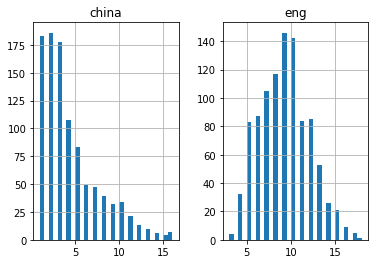

In [22]:
# empty lists
china_l = []
eng_l = []

# populate the lists with sentence lengths
for i in china[:,0]:
      china_l.append(len(i.split()))

for i in eng[:,0]:
      eng_l.append(len(i.split()))

length_df = pd.DataFrame({'china':china_l, 'eng':eng_l})

length_df.hist(bins = 30)
plt.show()

In [23]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [25]:
# prepare english tokenizer
china_tokenizer = tokenization(china[:, 0])
china_vocab_size = len(china_tokenizer.word_index) + 1

china_length = 20
print('China Vocabulary Size: %d' % china_vocab_size)

China Vocabulary Size: 3084


In [26]:
# prepare english tokenizer
eng_tokenizer = tokenization(eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 20
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 3349


In [27]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### model building
We will now split the data into train and test set for model training and evaluation, respectively.

In [29]:
from sklearn.model_selection import train_test_split

# split data into train and test set
# China text
train1, test1 = train_test_split(china, test_size=0.3, random_state = 12)

In [30]:
from sklearn.model_selection import train_test_split

# split data into train and test set
# eng text
train2, test2 = train_test_split(eng, test_size=0.3, random_state = 12)

In [31]:
# prepare training data
trainX = encode_sequences(china_tokenizer, china_length, train1[:, 0])
trainY = encode_sequences(eng_tokenizer, eng_length, train2[:, 0])

# prepare validation data
testX = encode_sequences(china_tokenizer, china_length, test2[:, 0])
testY = encode_sequences(eng_tokenizer, eng_length, test2[:, 0])

In [32]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [33]:
# model compilation
model = define_model(china_vocab_size, eng_vocab_size, china_length, eng_length, 512)

In [34]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [35]:
filename = 'model.h1.title_trans'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Train on 560 samples, validate on 140 samples
Epoch 1/30
560/560 [==============================] - 12s 22ms/step - loss: 8.1145 - val_loss: 7.6034

Epoch 00001: val_loss improved from inf to 7.60337, saving model to model.h1.title_trans
Epoch 2/30
560/560 [==============================] - 12s 22ms/step - loss: 7.2478 - val_loss: 4.1640

Epoch 00002: val_loss improved from 7.60337 to 4.16398, saving model to model.h1.title_trans
Epoch 3/30
560/560 [==============================] - 13s 22ms/step - loss: 4.2364 - val_loss: 3.8570

Epoch 00003: val_loss improved from 4.16398 to 3.85703, saving model to model.h1.title_trans
Epoch 4/30
560/560 [==============================] - 14s 25ms/step - loss: 3.8375 - val_loss: 3.9448

Epoch 00004: val_loss did not improve from 3.85703
Epoch 5/30
560/560 [==============================] - 14s 25ms/step - loss: 3.8201 - val_loss: 3.9321

Epoch 00005: val_loss did not improve from 3.85703
Epoch 6/30
560/560 [==============================] - 13s 24ms

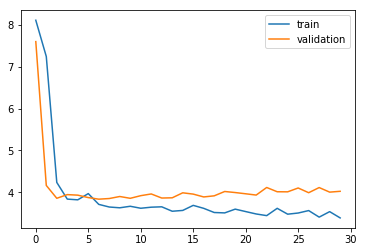

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [46]:
model = load_model('model.h1.title_trans')
preds = model.predict_classes(testX.reshape((testX.shape[0],testY.shape[0])))

ValueError: cannot reshape array of size 6000 into shape (300,300)

In [39]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [42]:
preds_text1 = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], china_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], china_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text1.append(' '.join(temp))

In [45]:
pred_df1 = pd.DataFrame({'actual' : test1[:,0], 'predicted' : preds_text})
pred_df1.sample(15)

,actual,predicted
246,銀欣 cpu03susb轉lightning 傳輸線mfi蘋果原廠認證銀色,
115,oppo r17 a73s a75s r15 pro r11s plus findx ax5 手機殼 聖誕雪花鑽殼,
23,情侶短袖t 夏季水洗33數字短袖t,
80,gatsby體用抗菌濕巾極凍冰橙超值包,
270,ifairies 單肩斜背包側背包肩背包【49146】,
248,【ur8d】ferrari 法拉利 red power熱力男性淡香水75ml,
141,多彩舒適棉素面百搭polo短衫天使白,
35,adidas 愛迪達 accel short 運動短褲 休閒短褲 ce6969,
260,羽絨外套 保暖首選亮眼字母刺繡羽絨棉外套 艾爾莎【tgk5919】,
236,【babyeo】任選2入 小寶貝立體矽膠圍兜五款可選,
